<a href="https://colab.research.google.com/github/hashPhoeNiX/ColabNotebooks/blob/master/Marine_Invertebrates_Indentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Splitting data into train and validation set

In [ ]:
# !pip install split-folders tqdm

In [ ]:
# import split_folders

# split_folders.ratio('train_small', output='data', seed=1337, ratio=(.8, .1, .1))

## Import Libraries

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.pyplot as plt
from PIL import Image
 
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import random_split

## Data Augmentation

In [ ]:
train_dir = 'data/train/'
valid_dir = 'data/val'
test_dir = 'data/test'

## An idea


In [ ]:
# doing data augmentation 
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.RandomRotation(45),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])

In [ ]:
# splitting the data into train/validation/test sets
data = datasets.ImageFolder('train_small')
train_size = int(len(data)*0.9)
val_size = int((len(data)-train_size)*0.7)
test_size = int(len(data)-train_size-val_size)
train_data,val_data,test_data = random_split(data,[train_size,val_size,test_size])
print(f'train size: {len(train_data)}\nval size: {len(val_data)}\ntest size: {len(test_data)}')

train size: 2799
val size: 218
test size: 94


In [ ]:
train_data.dataset.transform = train_transform
val_data.dataset.transform = val_transform
test_data.dataset.transform = test_transform

batch_size = 16
trainloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
validloader = torch.utils.data.DataLoader(val_data,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

## Original idea


In [ ]:
# train_transform = transforms.Compose([transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(299),
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.ToTensor()
#                                       ])
# test_transform = transforms.Compose([transforms.RandomResizedCrop(299),
#                                       transforms.ToTensor()
#                                     ])
 
# trainset = datasets.ImageFolder(train_dir, transform=train_transform)
# validset = datasets.ImageFolder(valid_dir, transform=test_transform)
# testset = datasets.ImageFolder(test_dir, transform=test_transform)

In [ ]:
# trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=32)
# validloader = torch.utils.data.DataLoader(validset, shuffle=True, batch_size=32)
# testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=32)

In [ ]:
# len(trainset) + len(testset) + len(validset)

3111

## Transfer Learning

In [ ]:
def imshow_original(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.transpose((1, 2, 0))
 
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
 
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
 
    return ax

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
 
# imshow_original(images)

<class 'torch.Tensor'>
torch.Size([16, 3, 224, 224])
torch.Size([16])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Model Training using VGG Pretrained Network


In [ ]:
# defining model evaluation function
 
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return (100 * correct / total)

In [ ]:
# Loading Pretrained Network from torchvision.models
vgg = models.vgg16_bn(pretrained=False)
 
# Freezing the model parameters
for param in vgg.parameters():
    param.requires_grad = False
 
# Building a new vgg model classifier
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, 137)
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)
 
# define loss and model optimizer
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg.parameters(),lr=0.003)

torch.Size([137, 4096])
torch.Size([137])


In [ ]:
# %%time
# import copy
 
# loss_epoch_arr = []
# max_epochs = 15
# batch_size = 32
# min_loss = 10000000
 
# n_iters = np.ceil(5300/batch_size)
 
# for epoch in range(max_epochs):
 
#     for i, data in enumerate(trainloader, 0):
 
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
 
#         opt.zero_grad()
 
#         outputs = vgg(inputs)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         opt.step()
        
#         if min_loss > loss.item():
#             min_loss = loss.item()
#             best_model = copy.deepcopy(vgg.state_dict())
#             print('Min loss %0.2f' % min_loss)
        
#         if i % 100 == 0:
#             print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
#         del inputs, labels, outputs
#         torch.cuda.empty_cache()
        
#     loss_epoch_arr.append(loss.item())
 
# vgg.load_state_dict(best_model)
# print(evaluation(trainloader, vgg), evaluation(validloader, vgg))

Min loss 5.30
Iteration: 0/166, Loss: 5.30
Min loss 5.23
Iteration: 100/166, Loss: 5.23
Iteration: 0/166, Loss: 7.86
Iteration: 100/166, Loss: 7.75
Iteration: 0/166, Loss: 9.49
Iteration: 100/166, Loss: 6.56
Iteration: 0/166, Loss: 14.45
Iteration: 100/166, Loss: 9.42
Iteration: 0/166, Loss: 9.51
Min loss 4.99
Iteration: 100/166, Loss: 8.05
Min loss 4.89
Iteration: 0/166, Loss: 10.30
Iteration: 100/166, Loss: 9.86
Iteration: 0/166, Loss: 11.13
Iteration: 100/166, Loss: 11.13
Iteration: 0/166, Loss: 6.04
Iteration: 100/166, Loss: 7.07
Iteration: 0/166, Loss: 12.47
Iteration: 100/166, Loss: 9.31
Iteration: 0/166, Loss: 11.00
Iteration: 100/166, Loss: 8.82
Min loss 4.74
Iteration: 0/166, Loss: 9.67
Iteration: 100/166, Loss: 11.15
Iteration: 0/166, Loss: 11.50
Iteration: 100/166, Loss: 12.42
Iteration: 0/166, Loss: 9.21
Iteration: 100/166, Loss: 7.22
Iteration: 0/166, Loss: 9.86
Iteration: 100/166, Loss: 10.90
Iteration: 0/166, Loss: 16.23
Iteration: 100/166, Loss: 13.04
Min loss 4.52
16.7

In [ ]:
import time

def fit(model, criterion, optimizer, num_epochs=10):
    start = time.time()
    best_model = model.state_dict()
    best_acc = 0.0
    train_loss_over_time = []
    val_loss_over_time = []
    train_acc_over_time = []
    val_acc_over_time = []
    
    # each epoch has a training and validation phase
    for epoch in range(num_epochs):
        print(f'{epoch+1}/{num_epochs} epoch')
        
        for phase in ['train','val']:
            
            if phase == 'train':
                data_loader = trainloader
                model.train()                    # set the model to train mode
            else:
                data_loader = validloader
                model.eval()                    # set the model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0.0
            
            # iterate over the data
            for inputs,labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,pred = torch.max(outputs,dim=1)
                    loss = criterion(outputs,labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # calculating the loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)
                
            if phase == 'train':
                epoch_loss = running_loss/len(train_data)
                train_loss_over_time.append(epoch_loss)
                epoch_acc = running_corrects.double()/len(train_data)
                train_acc_over_time.append(epoch_acc)
            else:
                epoch_loss = running_loss/len(val_data)
                val_loss_over_time.append(epoch_loss)
                epoch_acc = running_corrects.double()/len(val_data)
                val_acc_over_time.append(epoch_acc)
                
            print(f'{phase} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = model.state_dict()
                
        print('-'*60)
    
    total_time = (time.time() - start)/60
    print(f'training complete in: {total_time:.3f} min\nbest accuracy: {best_acc:.3f}')
    # load best model weights
    model.load_state_dict(best_model)
    loss = {'train':train_loss_over_time, 'val':val_loss_over_time}
    acc = {'train':train_acc_over_time, 'val':val_acc_over_time}
    return model,loss,acc

In [ ]:
%time
epochs = 50
history, loss, acc = fit(vgg,loss_fn,opt,num_epochs=epochs)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
1/50 epoch
train loss: 11.652, acc: 0.255
val loss: 7.844, acc: 0.284
------------------------------------------------------------
2/50 epoch
train loss: 12.185, acc: 0.234
val loss: 9.289, acc: 0.225
------------------------------------------------------------
3/50 epoch
train loss: 11.603, acc: 0.268
val loss: 7.544, acc: 0.248
------------------------------------------------------------
4/50 epoch
train loss: 12.170, acc: 0.252
val loss: 7.811, acc: 0.284
------------------------------------------------------------
5/50 epoch
train loss: 11.515, acc: 0.255
val loss: 7.757, acc: 0.275
------------------------------------------------------------
6/50 epoch
train loss: 12.096, acc: 0.239
val loss: 7.519, acc: 0.243
------------------------------------------------------------
7/50 epoch
train loss: 11.977, acc: 0.251
val loss: 8.232, acc: 0.261
------------------------------------------------------------
8/50 epoch
train lo

In [ ]:
# loss, acc

In [ ]:
def evaluate(model,criterion):
    model.eval()       # setting the model to evaluate mode
    test_loss = 0.0
    test_acc = 0.0
    preds = []
    labels_list = []
    
    for inputs,labels in testloader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # predicting
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            _,pred = torch.max(outputs,dim=1)
            preds.append(pred)
            labels_list.append(labels)
        
        # calculating the loss and accuracy 
        test_loss += loss.item()*inputs.size(0)        
        correct = pred.eq(labels.data.view_as(pred))
        accuracy = torch.mean(correct.type(torch.FloatTensor))
        test_acc += accuracy.item() * inputs.size(0)
    
    # avreging the loss and accuracy
    test_loss = test_loss/len(testloader.dataset)
    test_acc = test_acc / len(testloader.dataset)
        
    print("test loss: {:.4f}  test acc: {:.4f}".format(test_loss,test_acc))
    return preds,labels_list

In [ ]:
# testing the model
predictions,labels = evaluate(vgg,loss_fn)

test loss: 8.7219  test acc: 0.2979


In [ ]:
# the model's name
model_name = 'model_vgg16.pt'
# saving the best trained model
torch.save(vgg.state_dict(), model_name)

In [ ]:
print("Acc on training set is {} and validation set is {}".format(evaluation(trainloader, vgg),evaluation(validloader, vgg)))

Acc on training set is 77.42050732404431 and validation set is 29.81651376146789


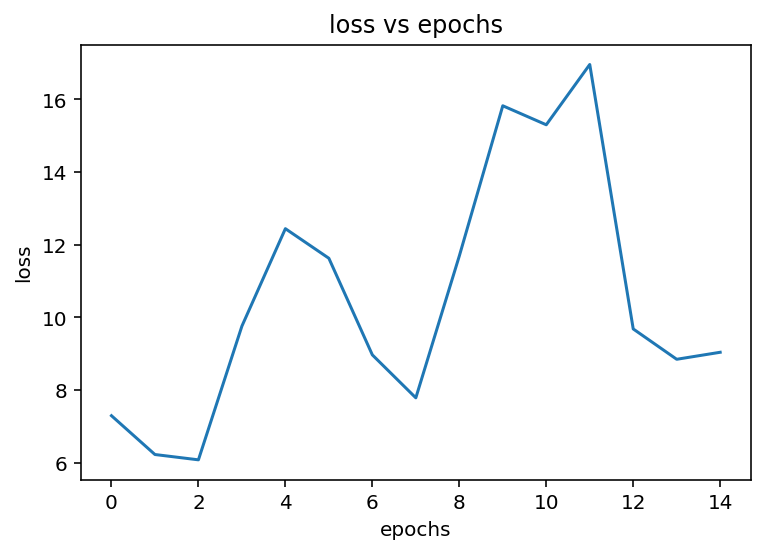

In [ ]:
plt.plot(loss_epoch_arr)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss vs epochs")
plt.show()